## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jaxquantum.codes as jqtb
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import numpy as np
from jax_tqdm import scan_tqdm
from jaxopt import GaussNewton
plt.style.use('ggplot')

/home/rolleri/.conda/envs/jax-sims/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check CUDA devs

In [3]:
jax.devices()

[CudaDevice(id=0)]

In [4]:
jax.devices()[0].memory_stats()

## Declare circuit parameters

In [5]:
N = 125
T = 100
kappa_0 = 0*1/100

t_R = 56 #ns
t_reset = 300 #ns
kerrs = jnp.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])*1e-9 #GHz
a = jqt.destroy(N)

In [6]:
linear_delays = np.load("cd_delay_times.npz", allow_pickle = True)["data"].tolist()[10.5]["total_ecd_times"][7:]

In [7]:
linear_betas = np.load("cd_delay_times.npz", allow_pickle = True)["data"].tolist()[10.5]["betas"][7:]

In [8]:
p = jnp.polyfit(linear_betas, linear_delays, 1)

In [9]:
def t_CD(beta):
    return jax.lax.max(linear_delays[0], jnp.polyval(p, beta)) #ns

In [10]:
betas = jnp.array(np.load("cd_delay_times.npz", allow_pickle = True)["data"].tolist()[10.5]["betas"])

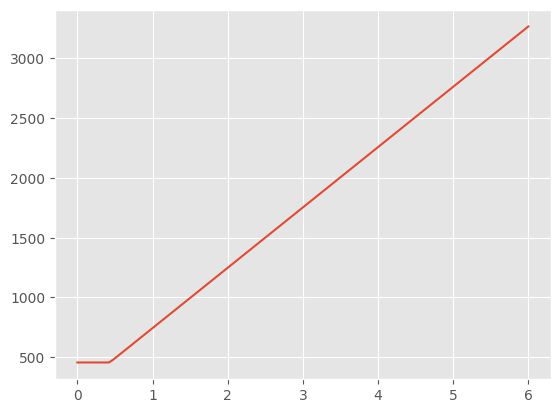

In [11]:
plt.plot(betas, t_CD(betas))

In [12]:
deltas = jnp.linspace(0.25, 0.5, 10)
l = jnp.sqrt(2*jnp.pi)
epsilon = jnp.sinh(deltas*deltas)*l

alphas_real = jnp.array([epsilon/2, jnp.zeros_like(epsilon), epsilon/2, jnp.zeros_like(epsilon), l*jnp.ones_like(epsilon), jnp.zeros_like(epsilon)])
alphas_imag = jnp.array([jnp.zeros_like(epsilon), -l*jnp.ones_like(epsilon), jnp.zeros_like(epsilon), epsilon/2, jnp.zeros_like(epsilon), epsilon/2])
alphas = alphas_real + alphas_imag * 1.j
T_0s = (5*t_R + t_CD(jnp.abs(alphas[0, :])) +t_CD(jnp.abs(alphas[1, :])) + t_CD(jnp.abs(alphas[2, :])) + t_reset)/1000
err_probs = 1-jnp.exp(-kappa_0*T_0s)

times = jnp.linspace(0, T*2*T_0s, T+1)

In [13]:
times.shape

(101, 10)

## Sweep circuit parameters

In [14]:
def sBs_half_round(initial_state, alphas, phis, thetas, err_prob, kerr):
    N = initial_state.space_dims[1]
    reg = jqtc.Register([2, N])

    cirq = jqtc.Circuit.create(reg, layers=[])

    def Ht(_):
        return kerr/2 * jqt.identity(2) ^ (a.dag() @ a.dag() @ a @ a)

    Idle_gate = jqtc.Id([2,N])
    Kerr = Idle_gate.add_Ht(Ht)
            
    cirq.append(jqtc.Ry(jnp.pi / 2, ts=jnp.linspace(0, t_R, 100)), 0, default_simulate_mode="hamiltonian")
    cirq.append(Kerr, [0,1], new_layer=False)
    cirq.append(jqtc.CD(N, alphas[0], ts=jnp.linspace(0, t_CD(jnp.abs(alphas[0])), 100)), [0, 1], default_simulate_mode="hamiltonian")
    cirq.append(Kerr, [0,1], new_layer=False)
    cirq.append(jqtc.Ry(phis[0], ts=jnp.linspace(0, t_R, 100)), 0, default_simulate_mode="hamiltonian")
    cirq.append(Kerr, [0,1], new_layer=False)
    cirq.append(jqtc.Rx(thetas[0], ts=jnp.linspace(0, t_R, 100)), 0, default_simulate_mode="hamiltonian")
    cirq.append(Kerr, [0,1], new_layer=False)
    cirq.append(jqtc.CD(N, alphas[1], ts=jnp.linspace(0, t_CD(jnp.abs(alphas[1])), 100)), [0, 1], default_simulate_mode="hamiltonian")
    cirq.append(Kerr, [0,1], new_layer=False)
    cirq.append(jqtc.Ry(phis[1], ts=jnp.linspace(0, t_R, 100)), 0, default_simulate_mode="hamiltonian")
    cirq.append(Kerr, [0,1], new_layer=False)
    cirq.append(jqtc.Rx(thetas[1], ts=jnp.linspace(0, t_R, 100)), 0, default_simulate_mode="hamiltonian")
    cirq.append(Kerr, [0,1], new_layer=False)
    cirq.append(jqtc.CD(N, alphas[2], ts=jnp.linspace(0, t_CD(jnp.abs(alphas[2])), 100)), [0, 1], default_simulate_mode="hamiltonian")
    cirq.append(Kerr, [0,1], new_layer=False)
    cirq.append(jqtc.Reset(), 0, default_simulate_mode="kraus")
    cirq.append(jqtc.selfKerr(N, kerr*t_reset), 1, default_simulate_mode="unitary")

    cirq.append(jqtc.Amp_Damp(N, err_prob, 20), 1, default_simulate_mode="kraus")

    res = jqtc.simulate(cirq, initial_state, mode='default')
    final_state = res[-1][-1]

    return final_state

In [15]:
@jax.jit
def sbs_batch(delta, kerr, err_prob):
    l = jnp.sqrt(2*jnp.pi)
    epsilon = jnp.sinh(delta*delta)*l

    alphas_real = jnp.array([epsilon/2, 0., epsilon/2, 0., l, 0.])
    alphas_imag = jnp.array([0., -l, 0., epsilon/2, 0., epsilon/2])
    alphas = alphas_real + alphas_imag * 1.j
    phis = jnp.array([0., 0., 0., 0.])
    thetas = jnp.array([jnp.pi/2, -jnp.pi/2, jnp.pi/2, -jnp.pi/2])

    
    gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": N})
    gkp = gkp_qubit.basis["+z"]

    initial_state = jqt.basis(2, 0) ^ gkp


    exp_Z0 = jnp.array([jnp.real(jqt.overlap(gkp_qubit.common_gates["Z_0"], initial_state.ptrace(1)))])
    
    initial_carry = initial_state.to_dm()
    
    @scan_tqdm(T)
    def sbs_round(carry, _):
        current_state = carry
        current_state = sBs_half_round(current_state, alphas[0:3], phis[0:2],
                                  thetas[0:2], err_prob, kerr)
        current_state = sBs_half_round(current_state, alphas[3:6], phis[2:4],
                                  thetas[2:4], err_prob, kerr)
        exp = jnp.real(jqt.overlap(gkp_qubit.common_gates["Z_0"], current_state.ptrace(1)))
        return (current_state, exp)

    final_carry, hist = jax.lax.scan(sbs_round, initial_carry, jnp.arange(T), length=T)

    exp_Z = jnp.concatenate((exp_Z0, hist))
    
    gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": N})
    gkp = gkp_qubit.basis["+x"]

    initial_state = jqt.basis(2, 0) ^ gkp


    exp_X0 = jnp.array([jnp.real(jqt.overlap(gkp_qubit.common_gates["X_0"], initial_state.ptrace(1)))])
    
    initial_carry = initial_state.to_dm()
    
    @scan_tqdm(T)
    def sbs_round(carry, _):
        current_state = carry
        current_state = sBs_half_round(current_state, alphas[0:3], phis[0:2],
                                  thetas[0:2], err_prob, kerr)
        current_state = sBs_half_round(current_state, alphas[3:6], phis[2:4],
                                  thetas[2:4], err_prob, kerr)
        exp = jnp.real(jqt.overlap(gkp_qubit.common_gates["X_0"], current_state.ptrace(1)))
        return (current_state, exp)

    final_carry, hist = jax.lax.scan(sbs_round, initial_carry, jnp.arange(T), length=T)

    exp_X = jnp.concatenate((exp_X0, hist))
    
    return 0.5*(exp_X + exp_Z)

In [16]:
def fit_t1(times, amps, guess):
    def exponential(x, x_data, y_data):
        return y_data-x[0]*jnp.exp(x[1]*x_data)
    gn = GaussNewton(residual_fun=exponential)
    gn_sol = gn.run(guess, x_data=times, y_data=amps)
    return gn_sol.params, gn_sol.state.error

In [17]:
sbs = jax.vmap(jax.vmap(sbs_batch, (0, 0, 0), 0), (0, 0, 0), 0)
fit_t1_vmap = jax.vmap(jax.vmap(fit_t1, (0, 0, None), 0), (0, 0, None), 0)

In [18]:
deltas_mg, kerrs_mg = jnp.meshgrid(deltas, kerrs)

In [19]:
err_probs_mg, kerrs_mg = jnp.meshgrid(err_probs, kerrs)

In [20]:
times_mg = times[:,None,:]
times_mg = np.repeat(times_mg, kerrs.shape[0], 1)

In [21]:
times_mg = jnp.swapaxes(jnp.swapaxes(times_mg, 0, 2), 0, 1)

In [ ]:
results = jnp.abs(sbs(deltas_mg, kerrs_mg, err_probs_mg))

Running for 100 iterations:   0%|                                                               | 0/100 [00:00<?, ?it/s]

In [ ]:
fit_res = fit_t1_vmap(times_mg, results, jnp.array([1., -0.005]))
coeff = fit_res[0]
residuals = fit_res[1]
mask_threshold = 1
mask = np.array(residuals<mask_threshold)
t1s = -1/coeff[:,:,1]
masked_t1s = np.ma.masked_array(np.array(t1s), np.logical_not(mask))

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 7))
handle = ax.pcolormesh(deltas_mg[1:], kerrs_mg[1:]*1e9, masked_t1s[1:], shading='nearest')
fig.colorbar(handle, ax=ax, label="Lifetime $[\\mu s]$")
ax.set_xlabel(r"$\Delta$")
ax.set_ylabel(r"$\text{K}_a\;[\text{Hz}]$")
ax.set_yscale("log")
ax.set_title("Logical lifetime; $\\kappa=(100\\mu s)^{-1}$")